# Training notebook

This notebook will take you through all the steps to train a CNN classifier, the first step in a CODEX analysis. Follow the cells in order, modify them where needed and run them all. Hints and defaults values are suggested. Follow the training curves with Tensorboard to check whether you are satisfied with the model (good classification performance, moderated overfitting). You will probably have to give it a couple of runs before being fully satisfied. Keep in mind that the training will be orders of magnitude faster on GPU compared to CPU.

## Import libraries

Make sure to import the model class, dataset class and the required preprocessing operations (RandomCrop, ToTensor, Subtract...).

In [1]:
# Standard libraries
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsampler import ImbalancedDatasetSampler
import datetime
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchsampler import ImbalancedDatasetSampler
import os
import zipfile
import time
import seaborn as sns
import pandas as pd
import warnings
import sys

# Custom functions/classes
path_to_module = '../source'  # Path where all the .py files are, relative to the notebook folder
sys.path.append(path_to_module)
from load_data import DataProcesser
from train_utils import even_intervals
from models import *
from class_dataset import myDataset, ToTensor, Subtract, RandomShift, RandomNoise, RandomCrop, FixedCrop

# For reproducibility
myseed = 7
pl.utilities.seed.seed_everything(myseed)

Global seed set to 7


7

## Define model architecture and set hyperparameters for training

Models are defined in the file `models.py`. There are already 2 models defined in this file: LitConvNetCam and LitConvNetCamBi. Both are variations of the same CNN architecture. While the former is for univariate input, the second is for bivariate input. These models are implemented with Pytorch-Lightning, a wrapper library around Pytorch, which also enables to simply the implementation of the training process. The file `models.py` also contains the implementation of these models in base pytorch. If you decide to use the latter, you will have to rewrite the training loop yourself.

For some parameters, you can leave the code to do an automatic inference by setting them to `None` (see later in the notebook). Read the description of the parameters below to know which parameters can be inferred automatically.

Hyperparameters to set the model dimensions:
- length: int or None. Length of the input time-series. If the input is multivariate, each channel will have the specified length. Setting it to a smaller value than the actual length of the trajectories can be used for data augmentation (see RandomCrop). If None, automatically detects the longest common length across al trajectories.
- nclass: int or None. Number of output classes. If None, automatically detects the number of unique values in the class column of the dataset.
- nfeatures: int, size of the input representation before the output layer. This also corresponds to the number of filters in the last convolution layer. Usually between 5 and 15.

Hyperparameters for training:
- nepochs: int, number of training epochs. Increase this if the loss curves are still decreasing at the end of the training. The range is very variable, but can be over hundreds.
- batch_size: int, number of samples per batch. Conventionally, this is set to a power of 2.
- L2_reg: float, L2 regularization factor. This helps to prevent overfitting by penalizing large weights in the model parameters. In general try to always have a mild regularization, say 1e-3. Increase if you face overfitting issues, decrease if you face underfitting.
- lr: float, initial learning rate. This is the most important parameter to tweak to have a smooth learning curve. 1e-2 is usually a good starting value.

By default, the learning rate is scheduled to decrease by a factor gamma at fixed epochs.
- lr_decrease_schedule: list of integers or None, epochs at which to decrease the learning_rate. If None, the number of epochs will be evenly divided in bins of the same length. 
- lr_decrease_factor: float, factor by which the lr is multiplied at the specified epochs. Usually between 0.1 (divide by 10) and 0.5 (divide by 2).

Other parameters:
- ngpu: int, number of GPU used to perform the training. -1 means use all; 0 means use CPU only.
- ncpu_LoadData: int, number of CPU cores used to load and preprocess the data that is passed to the network. This parameter is unrelated to `ngpu`: the model can be trained on GPU, while the data are loaded with CPU. If set too low, this parameter can become a bottleneck and slow down the training process.
- data_imbalance: boolean, whether to attempt at handling imbalanced dataset. Data imbalance arises when some classes are clearly overrepresented or underrepresented. This can lead to a strong bias in the training of the CNN, which will tend to classify the rare classes as one of the most common classes. If set to True, the rare classes will be oversampled and the common classes will be undersampled in each data batch. See: https://github.com/ufoym/imbalanced-dataset-sampler


In [2]:
# Architecture and dimensions of the model
length = None
nclass = None
nfeatures = 10

# Optimization parameters
nepochs = 5
batch_size = 64
L2_reg = 1e-3
lr = 1e-2
lr_decrease_schedule = None
lr_decrease_factor = 0.1

# Misc
ngpu = -1
ncpu_LoadData = 4
data_imbalance = False

## Load and process data, Data augmentation

Define which data to load and whether/how to preprocess the batch. 
- data_file: str, path to a .zip that can be loaded as a DataProcesser. The zip archive must contain 3 files: one for the
 data (dataset.csv), one for the split train/validation/test (id_set.csv), one with the classes descriptions (classes.csv). See DataProcesser.read_archive() for format details.
- meas_var: list of str or None, names of the measurement variables. In DataProcesser convention, this is the prefix in a
 column name that contains a measurement (time being the suffix). Pay attention to the order since this is how the dimensions of a sample of data will be ordered (i.e. 1st in the list will form 1st row of measurements in the sample, 2nd is the 2nd, etc...) If None, DataProcesser will extract automatically the measurement names and use the order of appearance in the column names.
- start_time/end_time: int or None, use to subset data to a specific time range. If None, DataProcesser will extract automatically the range of time in the dataset columns. Useful to completely exclude some acquisition times where irrelevant measures are acquired.

In [3]:
data_file = '../sample_data/Synthetic_Univariate.zip'
# data_file = '../sample_data/GrowthFactor_ErkAkt_Bivariate.zip'

meas_var = None
start_time = None
end_time = None

## Automatic inference of default parameters

Store the parameters into dictionaries for tidiness.

In [4]:
config_model = {
    'length': length,
    'nclass': nclass,
    'nfeatures': nfeatures,
    'batch_size': batch_size,
    'lr': lr,
    'lr_scheduler_milestones': lr_decrease_schedule,
    'lr_gamma': lr_decrease_factor,
    'L2_reg': L2_reg
    }

config_trainer = {
    'nepochs': nepochs,
    'ngpu': ngpu
}

all_inputs = {
    'data_file': data_file,
    'meas_var': meas_var,
    'start_time': start_time,
    'end_time': end_time,
    'ncpu_LoadData': ncpu_LoadData,
    'data_imbalance': data_imbalance,
    'seed': myseed,
    
}
all_inputs.update(config_model)
all_inputs.update(config_trainer)

This cell will update all the parameters that were set to None in the previous cells. A print statement will be shown for each inferred value.

In [5]:
# The data object is used to automatically derive some parameters (e.g. number of classes)
data = DataProcesser(data_file, datatable=False)

# Update default for the data
meas_var = data.detect_groups_times()['groups'] if meas_var is None else meas_var
start_time = data.detect_groups_times()['times'][0] if start_time is None else start_time
end_time = data.detect_groups_times()['times'][1] if end_time is None else end_time

# Choose architecture of the model according to data dimension
nmeasurement = len(meas_var)
if nmeasurement == 1:
    architecture = LitConvNetCam
    print('Monovariate measurement detected ({}), use {} architecture.'.format(meas_var, str(architecture)))
elif nmeasurement == 2:
    architecture = LitConvNetCamBi
    print('Bivariate measurement detected ({}), use {} architecture.'.format(meas_var, str(architecture)))
else:
    raise NotImplementedError('This script is intended for monovariate and bivariate measurements only.\
            To extend to higher dimensions, create the appropriate model in `models.py` and explicitely choose this architecture.')

# Update default for model
update_model = {}
if config_model['length'] is None:
    max_common_length = data.get_max_common_length()
    update_model['length'] = max_common_length
    print('Max common length detected: {}'.format(max_common_length))
if config_model['nclass'] is None:
    nclass_detected = data.dataset[data.col_class].nunique()
    update_model['nclass'] = nclass_detected
    print('Number of classes detected: {}'.format(nclass_detected))
if config_model['lr_scheduler_milestones'] is None:
    schedule = even_intervals(nepochs, ninterval=3)
    update_model['lr_scheduler_milestones'] = schedule
    print('Learning Rate will be decreased at epochs: {}'.format(schedule))
config_model.update(update_model)

Monovariate measurement detected (['FRST']), use <class 'models.LitConvNetCam'> architecture.
Max common length detected: 750
Number of classes detected: 2
Learning Rate will be decreased at epochs: [1, 3]


## Create objects with arguments

### Create model object

In [6]:
def make_model(architecture, **kwargs):
    model = architecture(**kwargs)
    model.double()
    return model

model = make_model(architecture=architecture, **config_model)

### Subset the data, set the input preprocessing and create dataset objects

In [7]:
# Select measurements and times, subset classes and split the dataset
data.subset(sel_groups=meas_var, start_time=start_time, end_time=end_time)
data.get_stats()
data.split_sets()

# Input preprocessing, this is done sequentially, on the fly when the input is passed to the network
average_perChannel = [data.stats['mu'][meas]['train'] for meas in meas_var]
ls_transforms = transforms.Compose([
    RandomCrop(output_size=config_model['length'], ignore_na_tails=True),
    Subtract(average_perChannel),
    ToTensor()])

# Define the dataset objects that associate data to preprocessing and define the content of a batch
# A batch of myDataset contains: the trajectories, the trajectories identifier and the trajecotires class identifier
data_train = myDataset(dataset=data.train_set, transform=ls_transforms)
data_validation = myDataset(dataset=data.validation_set, transform=ls_transforms)

if config_model['batch_size'] > len(data_train) or config_model['batch_size'] > len(data_validation):
    raise ValueError('Batch size ({}) must be smaller than the number of trajectories in the training ({}) and the validation ({}) sets.'.format(config_model['batch_size'], len(data_train), len(data_validation)))

# Quick recap of the data content
print('Channels order: {} \nTime range: ({}, {}) \nClasses: {}'.format(meas_var, start_time, end_time, list(data.dataset[data.col_class].unique())))
nclass_data = len(list(data.dataset[data.col_class].unique()))
if config_model['nclass'] != nclass_data:
    warnings.warn('The number of classes in the model output ({}) is not equal to the number of classes in the data ({}).'.format(config_model['nclass'], nclass_data))

Channels order: ['FRST'] 
Time range: (0, 749) 
Classes: [0, 1]


Plot some trajectories to check that the data loading and preprocessing is properly done. The curves appear here as they will be presented to the CNN.

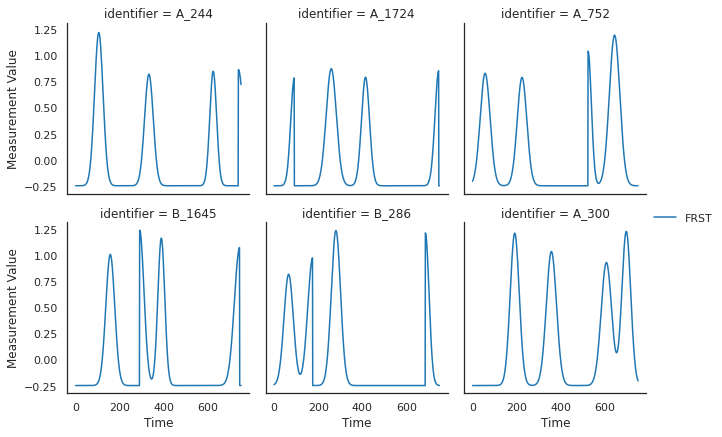

In [8]:
n_smpl = 6
indx_smpl = np.random.randint(0, len(data_train), n_smpl)

col_ids = []
col_lab = []
col_mes = []
# Long format for seaborn grid, for loop to avoid multiple indexing
# This would triggers preprocessing multiple times and add randomness
for i in indx_smpl:
    smpl = data_train[i]
    col_ids.append(smpl['identifier'])
    col_lab.append(smpl['label'].item())
    col_mes.append(smpl['series'].numpy().transpose())
col_ids = pd.Series(np.hstack(np.repeat(col_ids, config_model['length'])))
col_lab = pd.Series(np.hstack(np.repeat(col_lab, config_model['length'])))
col_mes = pd.DataFrame(np.vstack(col_mes), columns=meas_var)
col_tim = pd.Series(np.tile(np.arange(0, config_model['length']), n_smpl))

df_smpl = pd.concat([col_ids, col_lab, col_tim, col_mes], axis=1)
df_smpl.rename(columns={0: 'identifier', 1: 'label', 2:'time'}, inplace=True)
df_smpl = df_smpl.melt(id_vars=['identifier', 'label', 'time'], value_vars=meas_var)

sns.set_style('white')
sns.set_context('notebook')
grid = sns.FacetGrid(data=df_smpl, col='identifier', col_wrap=3, sharex=True)
grid.map_dataframe(sns.lineplot, x='time', y='value', hue='variable')
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

## Tensorboard logs and model save file

Define where the directory where training logs will be saved and the file where the model will be saved. By default, creates two subdirectories in the working directory: models and logs. An unique name for the logs and the model is created by appending the measurement name to the current timestamp.

The model training can be monitored in real-time in Tensorboard with these logs.

In [9]:
file_data = os.path.splitext(os.path.basename(data_file))[0]  # file name without extension
timestamp = datetime.datetime.now().strftime('%Y-%m-%d-%H__%M__%S')

dir_logs = 'logs/'
subdir_logs = '_'.join(meas_var)
file_logs =  '_'.join([timestamp, file_data])
dir_model = 'models/' + '_'.join(meas_var)
file_model = '_'.join([timestamp, file_data])

if not os.path.exists(dir_model):
    os.makedirs(dir_model)
if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

tb_logger = pl.loggers.TensorBoardLogger(save_dir=dir_logs, name=subdir_logs, version=file_logs, default_hp_metric=False)

## Equivalent call with command line script

This table presents the correspondence between the variables set in this notebook and the arguments for the script `train_model.py`.

In [10]:
all_inputs['dir_logs'] = dir_logs
dict_script_inputs = {
    'data_file': '-d',
    'meas_var': '-m',
    'start_time': '--startTime',
    'end_time': '--endTime',
    'ncpu_LoadData': '--ncpuLoad',
    'length': '-l',
    'nclass': '-c',
    'nfeatures': '-f',
    'batch_size': '-b',
    'lr': '-r',
    'lr_scheduler_milestones': '-s',
    'lr_gamma': '-g',
    'L2_reg': '-p',
    'nepochs': '-e',
    'ngpu': '--ngpu',
    'seed': '--seed',
    'dir_logs': '--logdir'
}
dict_script_inputs['data_imbalance'] = '--imba' if data_imbalance else '--no-imba'

df_inputs = pd.DataFrame.from_dict(all_inputs, orient='index', columns=['value'])
df_inputs['script_name'] = pd.Series(dict_script_inputs)
df_inputs

,value,script_name
data_file,../sample_data/Synthetic_Univariate.zip,-d
meas_var,None,-m
start_time,None,--startTime
end_time,None,--endTime
ncpu_LoadData,4,--ncpuLoad
data_imbalance,False,--no-imba
seed,7,--seed
length,None,-l
nclass,None,-c
nfeatures,10,-f


Hence, the same training could have been obtained with the following call from the command line (make sure that the right conda environment is activated):

In [11]:
# Do not include inferred parameters for conciseness
df_script = df_inputs[df_inputs['value'].notna()].drop('data_imbalance')
call = 'python ../source/train_model.py ' + ' '.join(df_script['script_name'] + ' ' + df_script['value'].astype('str'))
call = (call + ' --imba') if data_imbalance else call
print(call)

python ../source/train_model.py -d ../sample_data/Synthetic_Univariate.zip --ncpuLoad 4 --seed 7 -f 10 -b 64 -r 0.01 -g 0.1 -p 0.001 -e 5 --ngpu 0 --logdir logs/


## Train the model

Can follow the training in tensorboard with:
```
tensorboard --logdir "path/to/logs"
```

In [ ]:
if data_imbalance:
     train_sampler = ImbalancedDatasetSampler(data_train, callback_get_label=get_label_forImbaSampler)
     train_shuffle = False
else:
     train_sampler = None
     train_shuffle = True

train_loader = DataLoader(dataset=data_train,
                          batch_size=config_model['batch_size'],
                          shuffle=train_shuffle,
                          sampler=train_sampler,
                          num_workers=ncpu_LoadData,
                          drop_last=True)

validation_loader = DataLoader(dataset=data_validation,
                               batch_size=config_model['batch_size'],
                               shuffle=False,
                               num_workers=ncpu_LoadData,
                               drop_last=True)

t0 = time.time()
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(
     callbacks=[
       lr_monitor
     ],
     max_epochs=nepochs,
     min_epochs=nepochs,
     gpus=ngpu,
     log_every_n_steps=1,
     logger=tb_logger,
     benchmark=True
)
trainer.fit(model, train_loader, validation_loader)
file_model = tb_logger.log_dir + '.pytorch'
torch.save(model, file_model)
t1 = time.time()

print('Elapsed time: {:.2f} min'.format((t1 - t0)/60))

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/marc/anaconda3/envs/new_codex/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name       | Type             | Params
------------------------------------------------
0 | loss       | CrossEntropyLoss | 0     
1 | train_acc  | Accuracy         | 0     
2 | val_acc    | Accuracy         | 0     
3 | train_f1   | F1               | 0     
4 | val_f1     | F1               | 0     
5 | features   | Sequential       | 8.2 K 
6 | pool       | AvgPool1d        | 0     
7 | classifier | Sequential       | 22    
------------------------------------------------
8.3 K     Trainable params
0         Non-trainable params
8.3 K     Total params
0.033     Total estimated model params size (MB)


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s]

## What's next

- Make sure that you are satisfied with the model. A quick way to do this is to check the Tensorboard logs. Check in priority if the classification performance are good enough (top1/top2 indicators) and that there is no serious problems of overfitting (difference between the training and validation sets should remain reasonably small).
- When possible, try to play around with the parameters before deciding on a given model. In priority, try to tweak the initial learning rate by a few orders of magnitude and the learning rate scheduler to see if you can get a smoothly converging training curve. If your model is overfitting try to reduce the number of features or to increase the L2 regularization strength.
- When you are satisfied with the model, you can go on the next notebooks to identify prototype trajectories and to identify class-discriminative motifs with CAMs.
- Alternatively, you can use the companion app to browse an interactive projection of the CNN features.

## Details and tips to setup loss and optimizer

The loss (called criterion in pytorch convention) against which the model is trained is defined here. For regular classification tasks use the CrossEntropyLoss. All available options are listed here: https://pytorch.org/docs/1.1.0/nn.html#loss-functions

The optimizer defines which algorithm is used to update the weights of the model through the training. L2 regularization is controlled by the "weight_decay" argument in the optimizer object. Adam optimizer with default parameters is a good default. All available options are listed here: https://pytorch.org/docs/1.1.0/optim.html#algorithms

Scheduler defines how the learning rate should evolve through the training. In order to get a smooth training and better classification performance, it needs to be reduced after some epochs. One of the easiest scheduler is the MultiStepLR which reduces the learning rate by a factor gamma when milestone epochs are reached. To start, just try to divide the learning rate by a factor 0.1, 3-4 times through the training. All available options are listed here: https://pytorch.org/docs/1.1.0/optim.html#how-to-adjust-learning-rate